In [1]:
rows = 1025
cols = 50

In [2]:
import librosa
import numpy as np
import cv2
import glob

In [3]:
def store_stft_npy(fname):
    y, sr = librosa.load('Audio_Data/new_data/'+fname)
    STFT = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    STFT = cv2.resize(STFT.astype('float'), (cols, rows), interpolation = cv2.INTER_CUBIC)
    np.save('en_stft_npy/'+fname, STFT)
    
filename = glob.glob(r'Audio_Data/new_data/*.wav')
for i in range(len(filename)):
    # mac
    # filename[i] = filename[i].split('/')[1]
    # window
    filename[i] = filename[i].split('\\')[1]
    store_stft_npy(filename[i])

In [4]:
def store_stft_npy(fname):
    y, sr = librosa.load('Audio_Data/spoken_numbers_pcm/'+fname)
    STFT = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    STFT = cv2.resize(STFT.astype('float'), (cols, rows), interpolation = cv2.INTER_CUBIC)
    np.save('en_stft_npy/'+fname, STFT)
filename = glob.glob(r'Audio_Data/spoken_numbers_pcm/*.wav')
for i in range(len(filename)):
    filename[i] = filename[i].split('\\')[1]
    store_stft_npy(filename[i])

In [5]:
# 更新rows和cols
rows = 300
cols = 50

In [6]:
#%% 讀取npy，總共2400筆，2100做train、300做test
import random
from keras.utils import np_utils
x_list = []
y_list = []
filename_npy = glob.glob(r'en_stft_npy/*.npy')
random.shuffle(filename_npy)
for i in range(len(filename_npy)):
    ## 砍掉上半
    x_tmp = np.load(filename_npy[i])[:rows,:]
    x_list.append(x_tmp)
    # mac
    # y_list.append(filename_npy[i].split('/')[1][0])
    # window
    y_list.append(filename_npy[i].split('\\')[1][0])

Using TensorFlow backend.


In [7]:
len(x_list)

2880

In [9]:
# 2500做train、380做test
div = 2500
x_train = np.asarray(x_list[:div])
y_train = np.asarray(y_list[:div])
x_test = np.asarray(x_list[div:])
y_test = np.asarray(y_list[div:])

x_train = x_train.reshape(-1,rows,cols,1)
x_test = x_test.reshape(-1,rows,cols,1)

print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

# normalized和1-hot
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

5.70941244386 -88.3902387788
2.55652086983 -86.7047296969


In [13]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# import package
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

In [11]:
tf.test.is_gpu_available()

True

In [14]:
#%% model
model = Sequential()

input_shape = (rows, cols, 1)

model.add(Conv2D(16, (7, 7), padding='same', input_shape=input_shape))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0005),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 300, 50, 16)       800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 300, 50, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 25, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 25, 16)       64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 25, 32)       12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 150, 25, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 13, 32)        0         
__________

In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_acc', patience=5, verbose=1)

In [17]:
#%% fit model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          validation_data = (x_test, y_test),
                          shuffle = True,
                          callbacks=[early_stopping]
                         )

Train on 2500 samples, validate on 380 samples
Epoch 1/100
2500/2500 [==============================] - 7s 3ms/step - loss: 2.6111 - acc: 0.2228 - val_loss: 4.0252 - val_acc: 0.1342
Epoch 2/100
2500/2500 [==============================] - 3s 1ms/step - loss: 1.8483 - acc: 0.3900 - val_loss: 3.6245 - val_acc: 0.2237
Epoch 3/100
2500/2500 [==============================] - 3s 1ms/step - loss: 1.4064 - acc: 0.5196 - val_loss: 3.7717 - val_acc: 0.2105
Epoch 4/100
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0526 - acc: 0.6264 - val_loss: 3.9476 - val_acc: 0.2395
Epoch 5/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.8055 - acc: 0.7260 - val_loss: 2.6664 - val_acc: 0.3316
Epoch 6/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.5862 - acc: 0.7948 - val_loss: 1.6141 - val_acc: 0.5158
Epoch 7/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4028 - acc: 0.8696 - val_loss: 3.6678 - val_acc: 0.2421
Epoch 8/

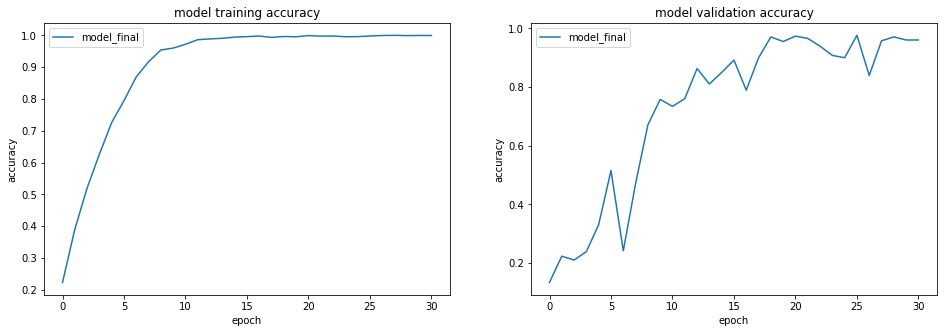

380/380 [==============================] - 1s 2ms/step
Loss: 0.096703
testing accuracy: 96.052629


In [18]:
#%% 作圖
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(model_history.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

ax2 = fig.add_subplot(1,2,2)
plt.plot(model_history.history["val_acc"])

plt.title("model validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

plt.show()

#%% score
score = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss: %f" %score[0])
print("testing accuracy: %f" %(score[1]*100))

In [19]:
#%% 儲存model
model.save('EN_STFT_CNN.h5')